# Predicción del rendimiento de computadoras con PyMC

![](figures/image.png)

> **Objetivos:**
>
> Generar un modelo predictivo Bayesiano para el rendimiento estimado de computadoras (ERP) utilizando caractarísticas de hardware.
>
> - Comprender ampliamente la naturaleza de los datos con los que se trabajarán.
> - Realizar un análisis exploratorio de datos que nos permita relacionar las variables explicativas con la variable objetivo.
> - Realizar un preprocesamiento a los datos que nos permitan realizar un modelamiento adecuado.
> - Proponer un modelo adecuado para el problema.
> - Realizar la modelación Bayesiana.
> - Evaluar el modelo com base en resultados obtenidos y métricas afines con le modelo propuesto.

> **Referencias:**
> 
> - https://archive.ics.uci.edu/dataset/29/computer+hardware

## Descripción del problema:

Se cuenta con un conjunto de registros de computadores con sus características de hardware (tiempo de ciclo, memoria mínima/máxima, cache, número de canales y medidas de rendimiento publicadas).

Se busca construir un modelo de regresión supervisada que prediga la variable ERP (Estimated Relative Performance). Además, se espera obtener un modelo interpretable que permita explicar qué atributos afectan más al rendimiento estimado.

Atributos del conjunto de datos:

- Variables explicativas (Características):
    - VendorName (categórica) [Fabricante de la computadora]
    - ModelName (categórica) [Nombre del modelo específico de la coputadora]
    - MYCT (numérica, en nanosegundos) [La velocidad del ciclo del procesador]
    - MMIN, MMAX (numérica, KB) [Cantidades de RAM mínimas y máximas admitidas]
    - CACH (numérica, KB) [Tamaño de la memoria cache]
    - CHMIN, CHMAX (numérica) [Número mínimo y máximo de canales I/O]
    - PRP (numérica) [Puntuación de rendimiento de referencia derivada del fabricante] — se puede usar como feature o target alternativo

- Variable objetivo:
    - ERP (Estimated Relative Performance) — variable continua.

In [1]:
with open(".style/set_themes.py", "r") as file:
    exec(file.read(), globals())

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/cpu-performance/machine.data",
    header=None,
)
df.columns = [
    "vendor_name",
    "model_name",
    "MYCT",
    "MMIN",
    "MMAX",
    "CACH",
    "CHMIN",
    "CHMAX",
    "PRP",
    "ERP",
]
df.head(10)

,vendor_name,model_name,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
0,adviser,32/60,125,256,6000,256,16,128,198,199
1,amdahl,470v/7,29,8000,32000,32,8,32,269,253
2,amdahl,470v/7a,29,8000,32000,32,8,32,220,253
3,amdahl,470v/7b,29,8000,32000,32,8,32,172,253
4,amdahl,470v/7c,29,8000,16000,32,8,16,132,132
5,amdahl,470v/b,26,8000,32000,64,8,32,318,290
6,amdahl,580-5840,23,16000,32000,64,16,32,367,381
7,amdahl,580-5850,23,16000,32000,64,16,32,489,381
8,amdahl,580-5860,23,16000,64000,64,16,32,636,749
9,amdahl,580-5880,23,32000,64000,128,32,64,1144,1238


In [3]:
# Obtenemos la cardinalidad de las variables categoricas
{cat_col: len(df[cat_col].unique()) for cat_col in ["vendor_name", "model_name"]}

{'vendor_name': 30, 'model_name': 209}

Previo al procesamiento se eliminarán:
- Las categóricas (VendorName, ModelName) por su alta cardinalidad, y...
- El performance relativo publicado (PRP), debido a la fuga de información que podría incluir en el modelo (time leakeage).

In [4]:
df = df.drop(columns=["vendor_name", "model_name", "PRP"])  # 'MYCT'?
df.head(10)

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,ERP
0,125,256,6000,256,16,128,199
1,29,8000,32000,32,8,32,253
2,29,8000,32000,32,8,32,253
3,29,8000,32000,32,8,32,253
4,29,8000,16000,32,8,16,132
5,26,8000,32000,64,8,32,290
6,23,16000,32000,64,16,32,381
7,23,16000,32000,64,16,32,381
8,23,16000,64000,64,16,32,749
9,23,32000,64000,128,32,64,1238


## Análisis Exploratorio de Datos

In [5]:
print(f"Dimensiones del conjunto de datos: {df.shape}\n")
print(f"Tipos de datos:\n{df.dtypes}\n")
print(f"Valores nulos por columna:\n{df.isnull().sum()}\n")
df.describe().round(3).T

Dimensiones del conjunto de datos: (209, 7)

Tipos de datos:
MYCT     int64
MMIN     int64
MMAX     int64
CACH     int64
CHMIN    int64
CHMAX    int64
ERP      int64
dtype: object

Valores nulos por columna:
MYCT     0
MMIN     0
MMAX     0
CACH     0
CHMIN    0
CHMAX    0
ERP      0
dtype: int64



,count,mean,std,min,25%,50%,75%,max
MYCT,209.0,203.823,260.263,17.0,50.0,110.0,225.0,1500.0
MMIN,209.0,2867.981,3878.743,64.0,768.0,2000.0,4000.0,32000.0
MMAX,209.0,11796.153,11726.564,64.0,4000.0,8000.0,16000.0,64000.0
CACH,209.0,25.206,40.629,0.0,0.0,8.0,32.0,256.0
CHMIN,209.0,4.699,6.816,0.0,1.0,2.0,6.0,52.0
CHMAX,209.0,18.268,25.997,0.0,5.0,8.0,24.0,176.0
ERP,209.0,99.330,154.757,15.0,28.0,45.0,101.0,1238.0


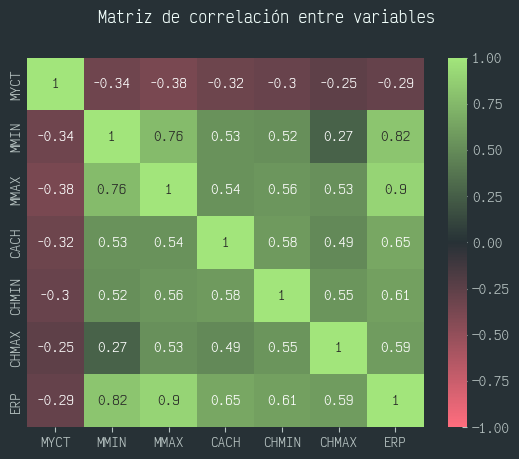

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(
    df.corr(numeric_only=True),
    annot=True,
    cmap=rdg_cmap,  # type: ignore
    vmin=-1,
    vmax=1,
)
plt.suptitle("Matriz de correlación entre variables")
plt.show()

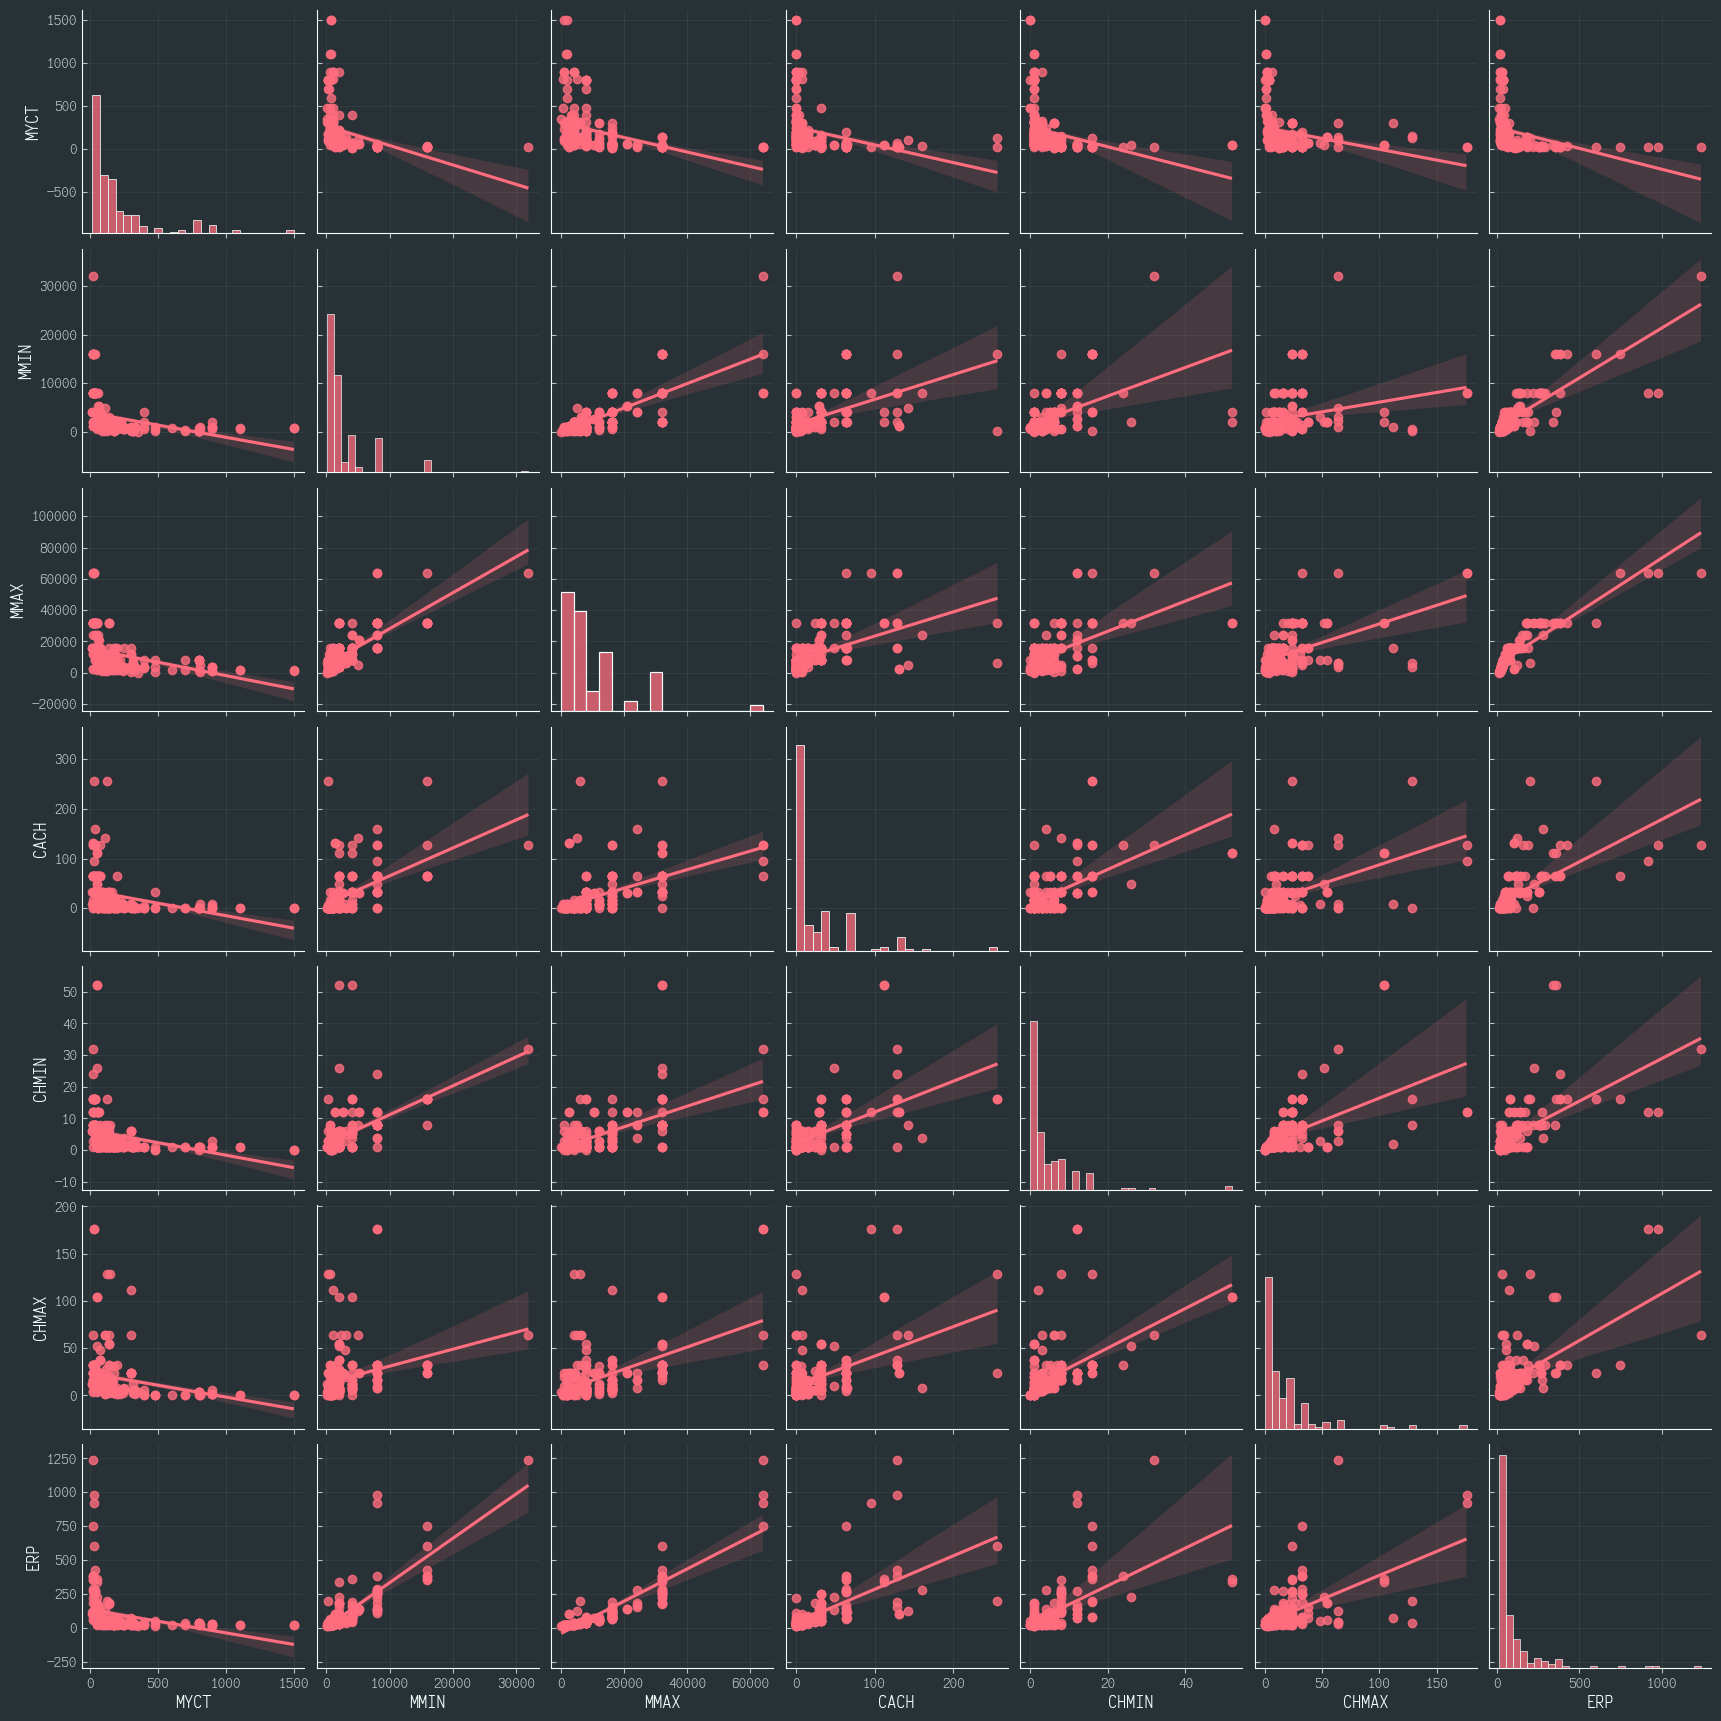

In [7]:
# sns.pairplot(df, kind='reg')
sns.pairplot(df, kind="reg")
plt.show()

## Preprocesamiento

In [8]:
from sklearn.model_selection import train_test_split

x = df.drop(columns=["ERP"])
y = df["ERP"]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

In [9]:
from sklearn.preprocessing import PowerTransformer

pt_x = PowerTransformer(method="yeo-johnson", standardize=True)
pt_y = PowerTransformer(method="yeo-johnson", standardize=True)

cols = x.columns

x_train_trans = pd.DataFrame(pt_x.fit_transform(x_train), columns=cols)
x_test_trans = pd.DataFrame(pt_x.transform(x_test), columns=cols)

y_train_trans = pd.DataFrame(
    pt_y.fit_transform(y_train.values.reshape(-1, 1)), columns=["ERP"]
)
y_test_trans = pd.DataFrame(
    pt_y.transform(y_test.values.reshape(-1, 1)), columns=["ERP"]
)

x_train_trans.head(10).round(4)

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX
0,-1.0678,1.4990,0.7382,0.8598,1.1913,0.4514
1,-1.5913,2.1700,1.6129,1.2440,1.1913,0.8237
2,-1.4138,1.4990,2.6163,1.6265,1.4811,2.6568
3,-0.0161,-0.4211,-0.6888,-1.2211,0.3121,0.8237
4,-1.4138,2.1700,1.6129,2.0050,1.6595,0.8237
5,0.2659,0.2037,-0.6888,-1.2211,0.5929,-0.1709
6,0.6097,-0.4211,-1.2680,-1.2211,-0.8057,-0.5730
7,-0.8098,0.2037,-0.0243,0.1062,-0.8057,-0.5730
8,1.0011,-2.1852,-0.3112,-1.2211,-0.8057,0.1902
9,0.7574,-1.0102,-1.2680,0.1062,-0.8057,-0.5730


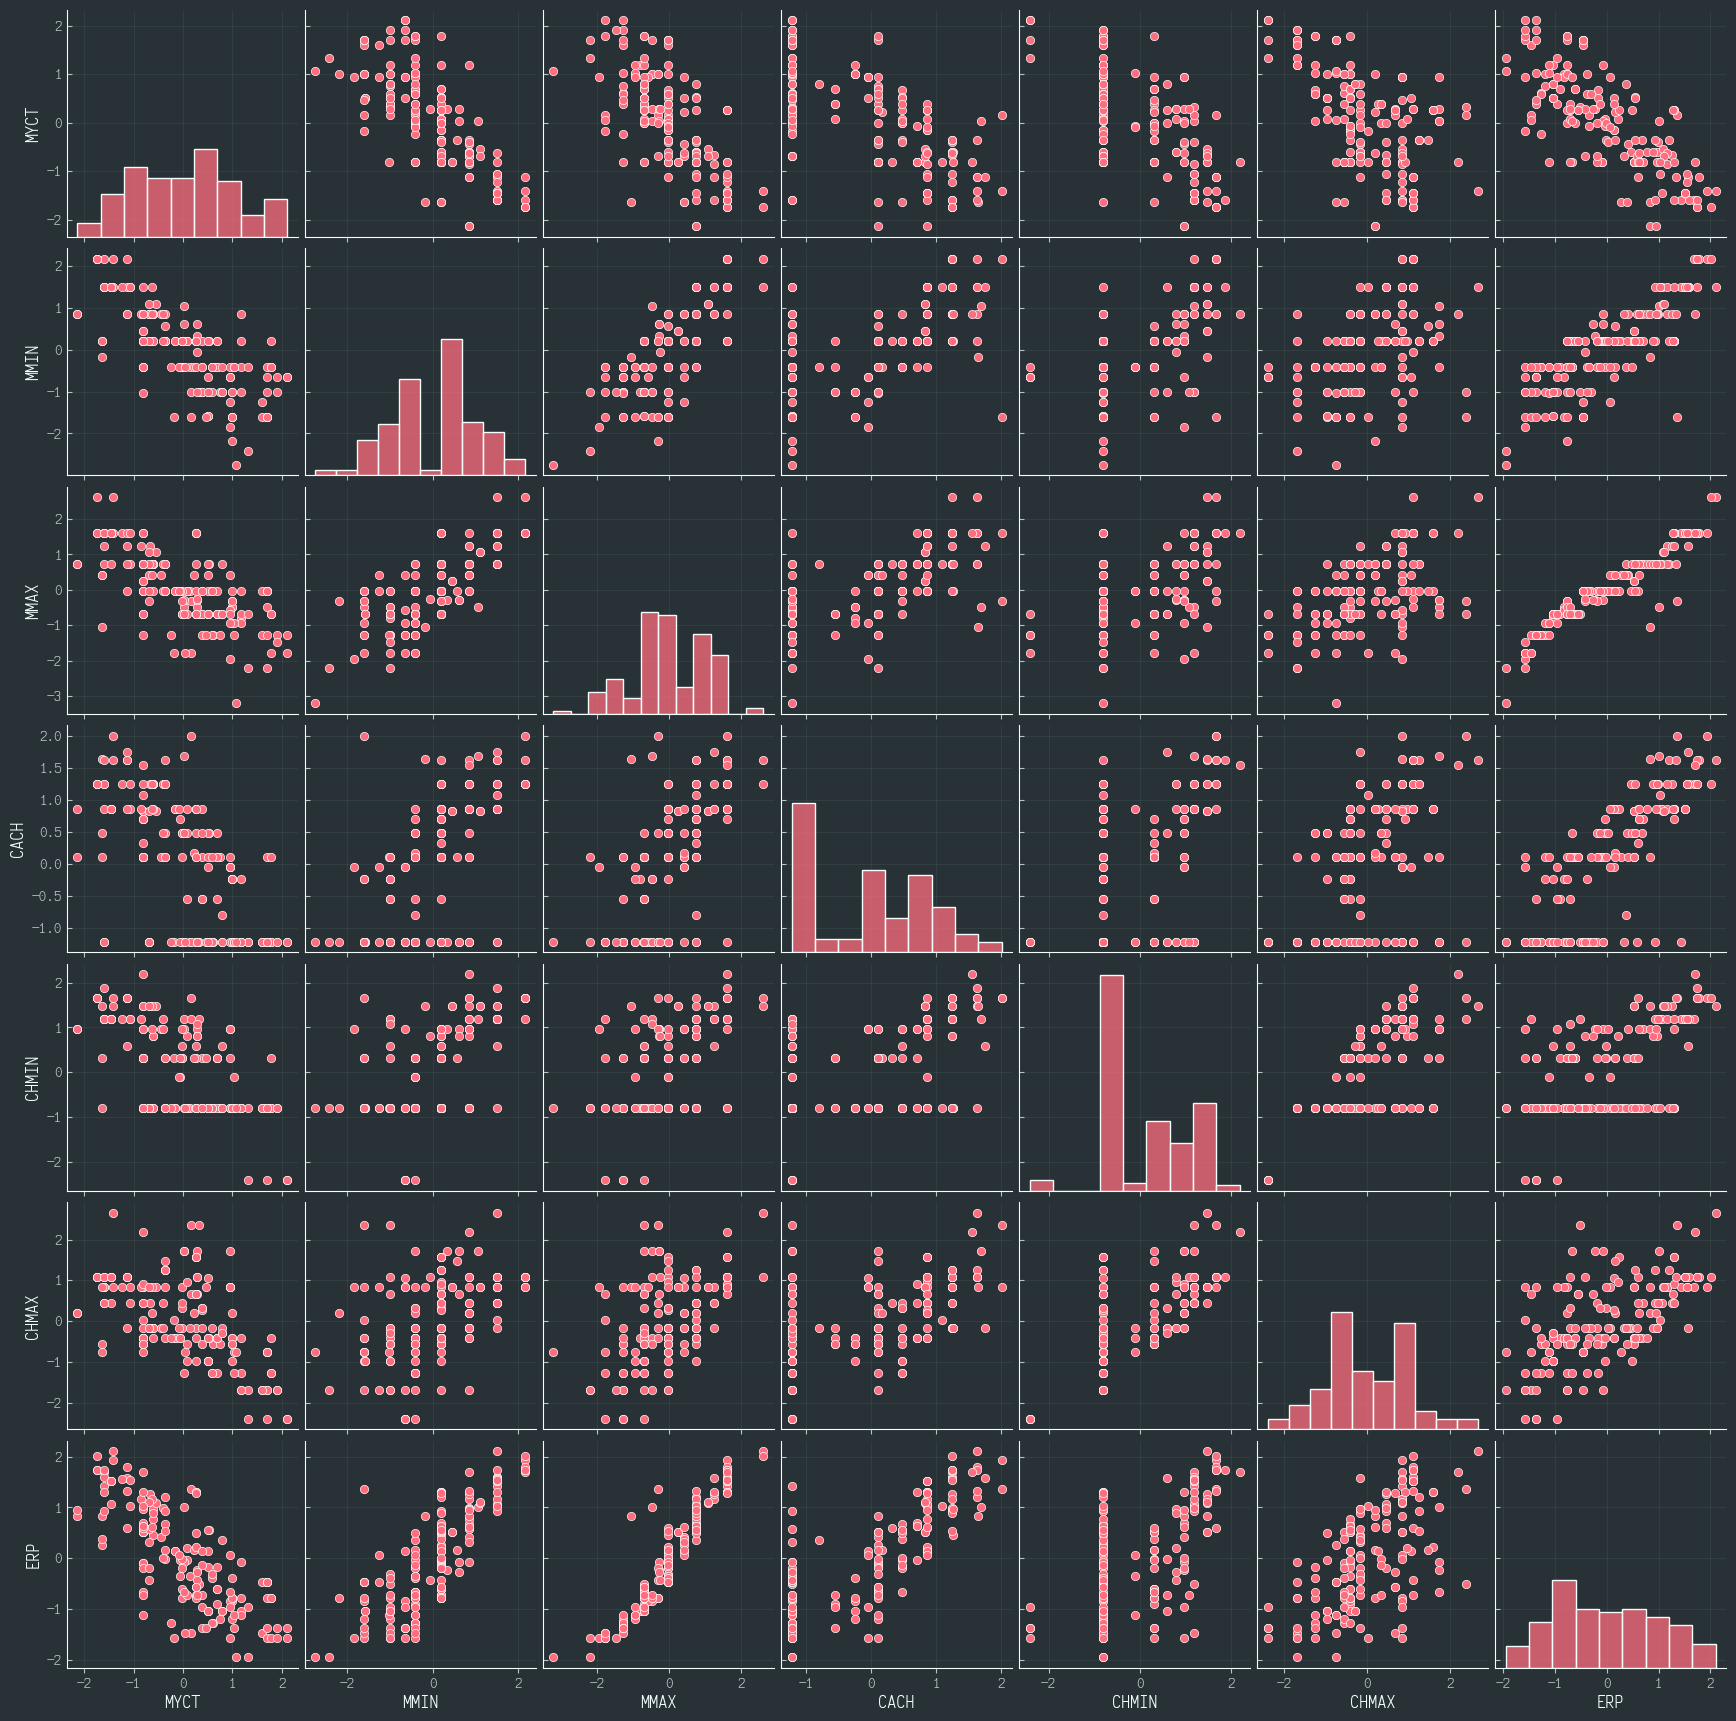

In [10]:
sns.pairplot(x_train_trans.assign(ERP=y_train_trans.iloc[:, 0]))
plt.show()

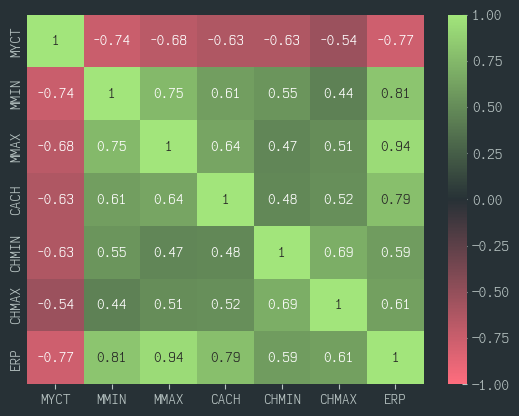

In [11]:
sns.heatmap(
    x_train_trans.assign(ERP=y_train_trans.iloc[:, 0]).corr(),
    annot=True,
    cmap=rdg_cmap,  # type: ignore
    vmin=-1,
    vmax=1,
)
plt.show()

## Estructura del modelo

Tras haber analizado las variables podemos ver que para este problema de regresión un modelo lineal es la estructura idónea.

Por lo que, se realizará un **Regresor lineal Bayesiano**.

Del mismo modo, las métricas para evaluar el modelo serán: RMSE, MAE, R².

## Definición del modelo


Variables predictivas seleccionadas:
- MMAX: tiene la mayor correlación con la variable objetivo.
- CACH: alta correlación con el objetivo, y poca con las otras variables.
- CHMIN: correlación relativamente baja con el objetivo pero también baja con las otras variables.

Limitaciones:
- ERP es una estimación (no medición directa) y puede contener sesgos.
- Algunas variables están fuertemente relacionadas entre sí, lo que limita las combinaciones de variables explicativas.

Suposiciones:
- Observaciones independientes.
- Las medidas numéricas son representativas del rendimiento.

Modelo en lenguaje probabilístico:

$$
\begin{align}
\begin{array}{lcl}
\text{ERP}_i & \sim & \text{Normal}(\mu_i, \sigma) \\

\mu_i & = & \alpha

+ \beta_\text{MMAX}(\text{MMAX\_st})
+ \beta_\text{CACH}(\text{CACH\_st})
+ \beta_\text{CHMIN}(\text{CHMIN\_st})

\\

\alpha & \sim & \text{Log-Normal}(0, 1) \\
\beta_\text{MMAX} & \sim & \text{Normal}(0, 1) \\
\beta_\text{CACH} & \sim & \text{Log-Normal}(0, 1) \\
\beta_\text{CHMIN} & \sim & \text{Log-Normal}(0, 1) \\
\sigma & \sim & \text{Half-Normal}(0, 1)
\end{array}
\end{align}
$$

Notas de selección de distribuciones:

- Para MMAX una distribución normal.
- Para CACH podríamos usar una distribución log-normal y en caso de que no funcione incluso una exponencial.
- Para CHMIN utilizaremos una log-normal...
- Los valores se seleccionaron entre 0 y 1 debido a la estandarización realizada por la transformación.

In [12]:
# Validacion de simulaciones predictiva previa

## Implementación en PyMC

In [13]:
import arviz as az
import pymc as pm

In [14]:
x_train_trans = x_train_trans.drop(columns=["MYCT", "MMIN", "CHMAX"])
x_test_trans = x_test_trans.drop(columns=["MYCT", "MMIN", "CHMAX"])

In [15]:
MMAX = np.array(x_train_trans["MMAX"].values)
CHMIN = np.array(x_train_trans["CHMIN"].values)
CACH = np.array(x_train_trans["CACH"].values)

y = np.array(y_train_trans["ERP"].values)

In [16]:
X = np.column_stack((MMAX, CHMIN, CACH))
n, p = X.shape

In [17]:
print("MMAX shape:", np.asarray(MMAX).shape)
print("CHMIN shape:", np.asarray(CHMIN).shape)
print("CACH shape:", np.asarray(CACH).ravel().shape)
print("x_train_transformed shape:", np.asarray(x_train_trans).shape)

MMAX shape: (167,)
CHMIN shape: (167,)
CACH shape: (167,)
x_train_transformed shape: (167, 3)


In [18]:
coords = {"obs": np.arange(len(x_train_trans)), "pred": np.arange(p)}

In [19]:
with pm.Model(coords=coords) as model:
    X_shared = pm.Data("X", X, dims=("obs", "predictor"))
    y_shared = pm.Data("y", y, dims=("obs",))

    mmax = pm.Data("MMAX", MMAX, dims="obs")
    chmin = pm.Data("CHMIN", CHMIN, dims="obs")
    cach = pm.Data("CACH", CACH, dims="obs")

    # Previas para parámetros desconocidos
    alpha = pm.LogNormal("alpha", mu=0, sigma=1)
    beta_MMAX = pm.Normal("beta_MMAX", mu=0, sigma=1)
    beta_CHMIN = pm.LogNormal("beta_CHMIN", mu=0, sigma=1)
    beta_CACH = pm.LogNormal("beta_CACH", mu=0, sigma=1)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Valor esperado de la salida
    mu = pm.Deterministic(
        "mu", alpha + beta_MMAX * mmax + beta_CHMIN * chmin + beta_CACH * cach
    )

    # Verosimilitud (distribución muestral) de las observaciones
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y_shared, dims="obs")

    # Chequeo de la posterior predictiva
    ppc = pm.sample_posterior_predictive(
        pm.sample(1000, tune=1000), var_names=["Y_obs"]
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_MMAX, beta_CHMIN, beta_CACH, sigma]


Output()

/home/toutl/icd/meb/.venv/lib/python3.11/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [Y_obs]


Output()

In [20]:
import pytensor

pytensor.config.exception_verbosity = "high"  # type: ignore

with model:
    idata = pm.sample(2000, tune=1000, return_inferencedata=True, random_seed=42)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_MMAX, beta_CHMIN, beta_CACH, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


## Interpretación y evaluación

In [21]:
variables = ["alpha", "beta_MMAX", "beta_CHMIN", "beta_CACH", "sigma"]

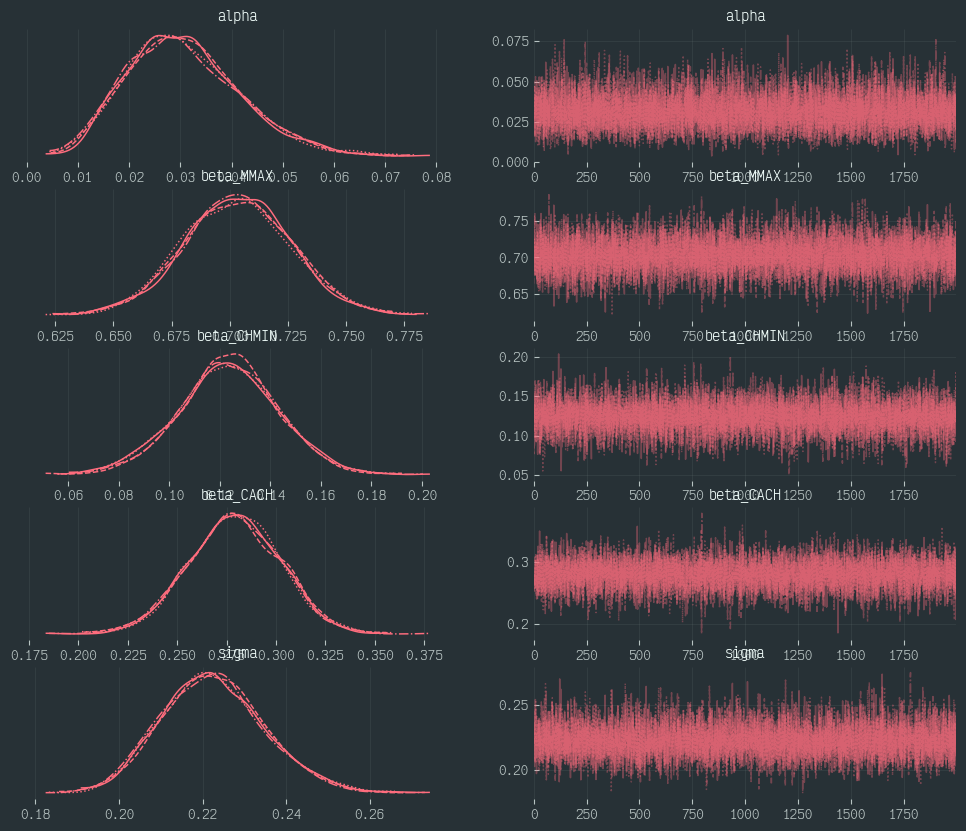

In [22]:
az.plot_trace(idata, var_names=variables)
plt.show()

Este grafico nos ayuda a identificar si realmente nuestro modelo es bueno.

Como podemos observar aquí, las cadenas estan mezcladas y tenemos lineas estables sin grandes tendencias, esto nos indica que, en efecto, tenemos un buen modelo.

In [23]:
az.summary(idata, var_names=variables)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.031,0.011,0.012,0.052,0.0,0.0,7653.0,4374.0,1.0
beta_MMAX,0.703,0.023,0.661,0.748,0.0,0.0,7899.0,6436.0,1.0
beta_CHMIN,0.123,0.020,0.087,0.162,0.0,0.0,7951.0,5031.0,1.0
beta_CACH,0.279,0.023,0.235,0.320,0.0,0.0,7712.0,5725.0,1.0
sigma,0.223,0.012,0.199,0.245,0.0,0.0,8160.0,6209.0,1.0


Puntos que podemos observar de este resumen
- Podemos ver que $\hat{R}$ tiende a uno, esto nos indica que tiene una muy buena convergencia. 
- Al `ess_bulk` y `ess_tail` ser números grandes, sabemos que tenemos suficiente cantidad de muestras efectivas.
- Por último, pero no menos importante, nuestro `MCSE` sale con numeros pequeños, lo que nos dice que nuestra media posterior es estable.

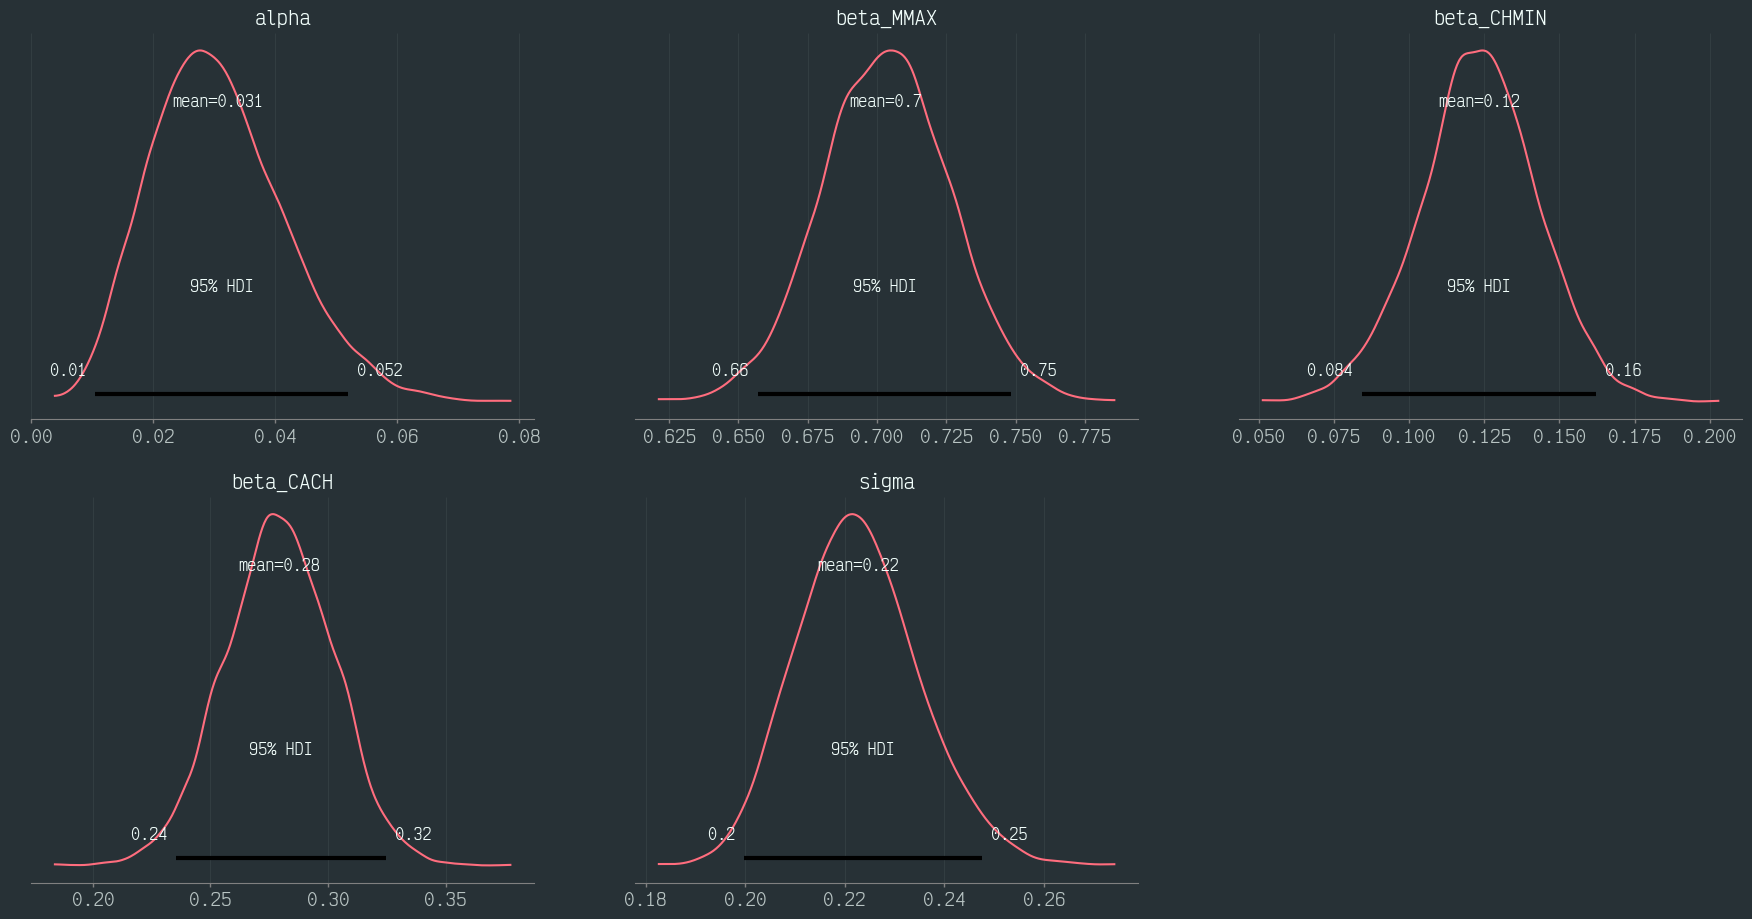

In [24]:
az.plot_posterior(idata, var_names=variables, hdi_prob=0.95)
plt.show()

Conclusiones de las graficas:
1. Todas las variables son importantes.

    Ningún HDI incluye cero, así que todas contribuyen al modelo.

2. `MMAX` es el predictor más fuerte.

    $\beta$ ≈ 0.63 domina sobre los demás.

3. `CACH` y `CHMIN` también aportan bastante.

    `CACH` ≈ 0.34
    `CHMIN` ≈ 0.14

4. El modelo está bien ajustado.

    $\sigma$ ≈ 0.21 nos indica un bajo ruido residual.

5. Las distribuciones son unimodales y bastante simétricas.

    Esto indica que el muestreo fue estable y la inferencia es confiable.

In [25]:
betas = idata["posterior"].stack(draws=("chain", "draw"))[
    ["beta_MMAX", "beta_CHMIN", "beta_CACH"]
]

betas.mean(dim="draws")

<xarray.Dataset> Size: 24B
Dimensions:     ()
Data variables:
    beta_MMAX   float64 8B 0.7032
    beta_CHMIN  float64 8B 0.1233
    beta_CACH   float64 8B 0.2791
Attributes:
    created_at:                 2025-12-05T01:24:16.063842+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.26.1
    sampling_time:              2.4224700927734375
    tuning_steps:               1000

Este análisis Bayesiano nos muestra que todas las variables predictoras presentan un efecto positivo en ERP.

- El coeficiente más alto corresponde a MMAX (β = 0.63), indicando que es la variable con mayor influencia en el modelo.
- Le sigue CACH (β = 0.34) con una contribución moderada.
- Y, finalmente CHMIN (β = 0.14), cuyo efecto aunque menor, continúa siendo relevante.

Estos valores representan las medias posteriores, reflejando las estimaciones más creíbles de los coeficientes dado el modelo y los datos observados.

In [26]:
with model:
    posterior_pred = pm.sample_posterior_predictive(idata)

Sampling: [Y_obs]


Output()

In [27]:
y_draws = posterior_pred["posterior_predictive"]["Y_obs"].values
y_draws = y_draws.reshape(-1, y_draws.shape[-1])
y_pred = y_draws.mean(axis=0)

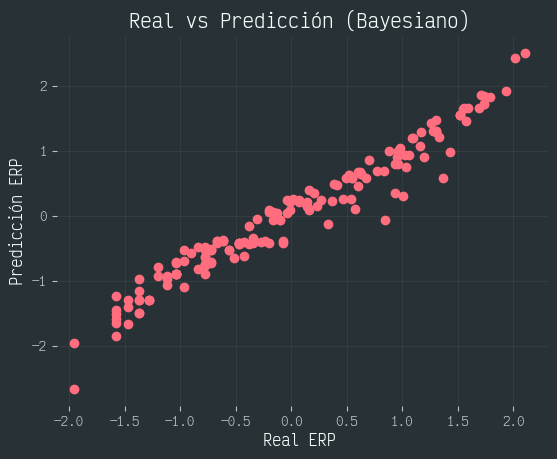

In [28]:
import matplotlib.pyplot as plt

plt.scatter(y_train_trans, y_pred)
plt.xlabel("Real ERP")
plt.ylabel("Predicción ERP")
plt.title("Real vs Predicción (Bayesiano)")
plt.show()

Aquí se puede observar que el modelo bayesiano tiene un excelente ajuste.

La gráfica demuestra que las predicciones siguen muy de cerca los valores reales, lo cual confirma que la regresión funciona de forma adecuada para capturar la variabilidad del ERP.

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_train_trans, y_pred)
mae = mean_absolute_error(y_train_trans, y_pred)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}")

MSE: 0.0480, MAE: 0.1575


Ambas métricas muestran que el modelo Bayesiano tiene un desempeño excelente:

- Errores muy bajos
- Predicciones muy cercanas a los valores reales
- No existen errores atípicos grandes

Las métricas confirman lo observado visualmente en la gráfica del punto 6: el modelo es altamente efectivo para predecir el ERP.